In [1]:
from IPython import display

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

# Obteniendo los archivos a analizar

In [3]:
schedule_names = ['fcfs', 'easy-backfill']

In [4]:
schedule_files = []
jobs_files = []
for folders in os.listdir('../output/'):
    for files in os.listdir('../output/' + folders):
        if files.endswith('_schedule.csv'):
            schedule_files.append(folders + "/" +  files)
        elif files.endswith('_jobs.csv'):
            jobs_files.append(folders + "/" + files)

schedule_files = [os.path.join('../output', str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/easy-backfill/easy-backfill_schedule.csv', '../output/fcfs/fcfs_schedule.csv']
['../output/easy-backfill/easy-backfill_jobs.csv', '../output/fcfs/fcfs_jobs.csv']


In [5]:
metrics = pd.DataFrame()
for file in schedule_files:
    print(file)
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[0]
        metrics = metrics.append(df)
    if schedule_name[1] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[1]
        metrics = metrics.append(df)
    print("----")
metrics.set_index('schedule', inplace=True)

../output/easy-backfill/easy-backfill_schedule.csv
----
../output/fcfs/fcfs_schedule.csv
----


In [6]:
jobsets = {}
for file in jobs_files:
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        print("reading", file)
        jobsets[schedule_name[0]] = JobSet.from_csv(file)
    if schedule_name[1] in schedule_names:
        print("reading", file)
        jobsets[schedule_name[1]] = JobSet.from_csv(file)

reading ../output/easy-backfill/easy-backfill_jobs.csv
reading ../output/fcfs/fcfs_jobs.csv


In [7]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [8]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [9]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [10]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [11]:
metrics.T

,fcfs,easy-backfill
batsim_version,4.0.0,4.0.0
consumed_joules,0,0
makespan,282315,275757
max_slowdown,58228,27200
max_turnaround_time,62823.6,73511.3
max_waiting_time,62809.3,72574.2
mean_slowdown,2159.23,652.617
mean_turnaround_time,14575.2,5679.64
mean_waiting_time,14360.9,5466.84
nb_computing_machines,4,4


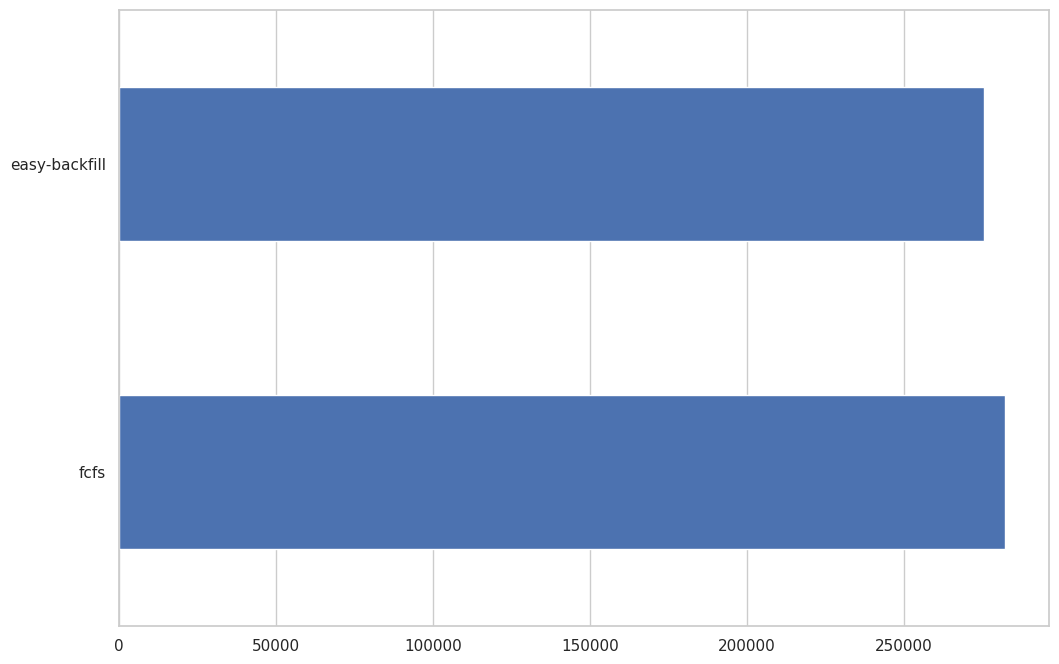

In [12]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

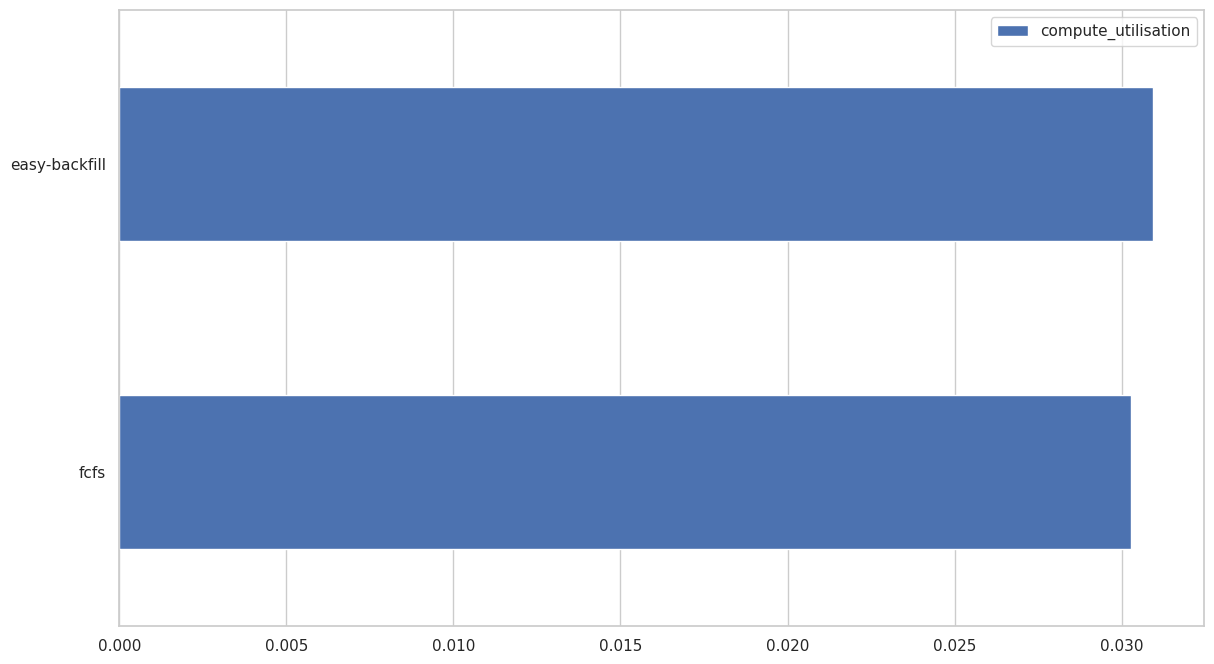

In [13]:
ax = metrics[['compute_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [14]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown
0,fcfs,0.000030,7.084905,1.000004
1,fcfs,7.086875,10.669659,2.978036
2,fcfs,10.671630,66.915805,1.189738
3,fcfs,66.917775,148.975018,1.815501
4,fcfs,7.086890,477.088817,1.015078
...,...,...,...,...
1584,easy-backfill,28068.761475,29427.985449,21.650579
1585,easy-backfill,29427.987434,29447.500677,1509.103351
1586,easy-backfill,23847.987419,24358.101219,47.750328
1587,easy-backfill,24478.103189,26395.207000,13.768272


In [15]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,fcfs,easy-backfill
count,1589.000000,1589.000000
mean,14360.891750,5466.843645
std,14058.592259,9360.608302
min,0.000030,0.000030
25%,3675.743498,31.154270
50%,9572.023219,641.250588
75%,22057.746673,6856.125122
max,62809.339831,72574.241834


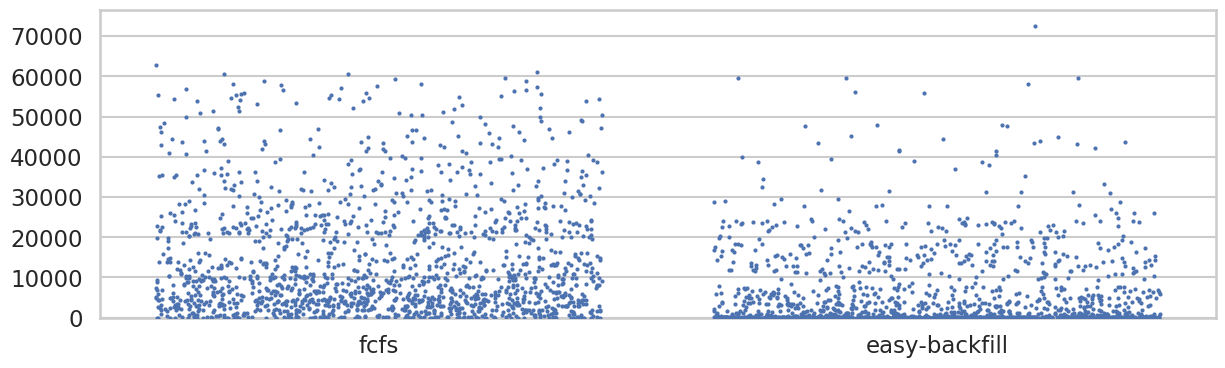

In [16]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/waiting-time_dist.pdf', bbox_inches='tight')

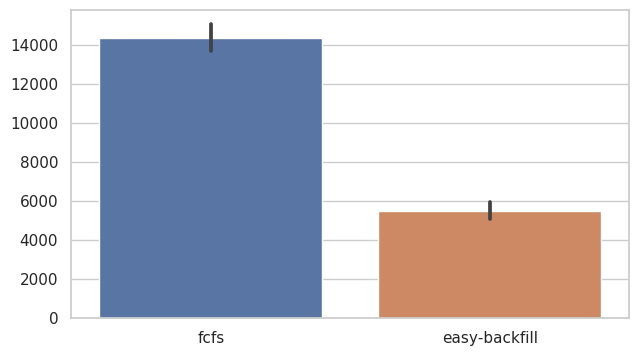

In [17]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=waiting_times, ax=ax)
fig.savefig('results/waiting-time_mean.pdf', bbox_inches='tight')

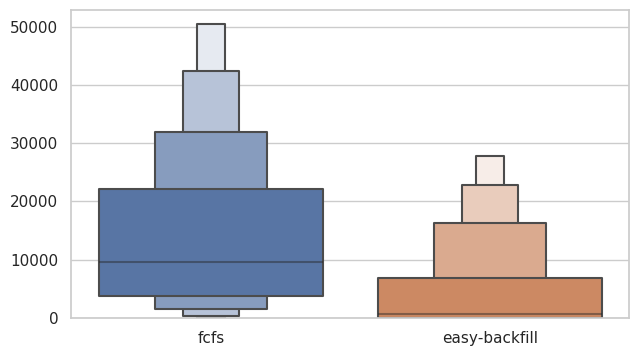

In [18]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/waiting-time_boxen.pdf', bbox_inches='tight')

In [19]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,fcfs,easy-backfill
count,1589.000000,1589.000000
mean,14575.165098,5679.642376
std,14077.513748,9520.719196
min,2.658599,0.881861
25%,3862.430959,58.999235
50%,9680.208487,766.521037
75%,22235.381669,7169.762159
max,62823.579836,73511.329790


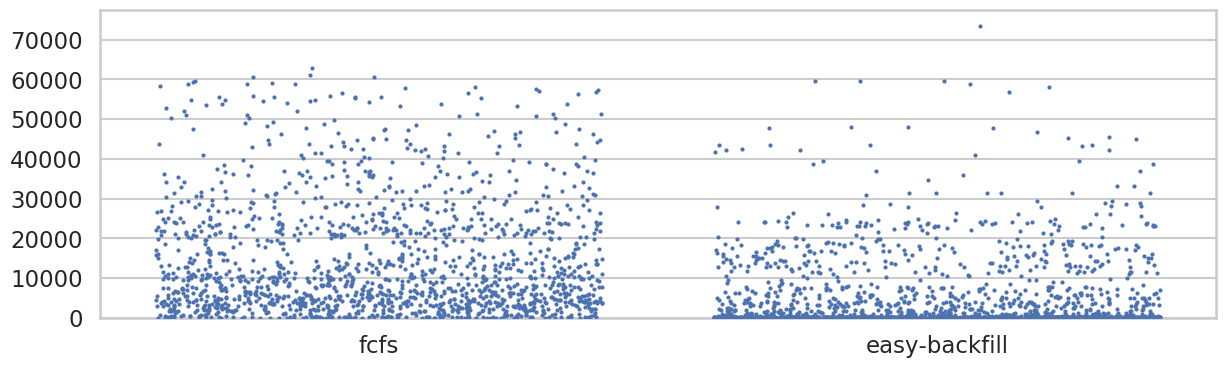

In [20]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/turnaround-time_dist.pdf', bbox_inches='tight')

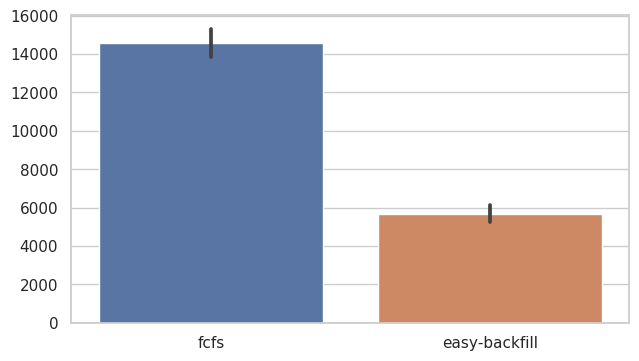

In [21]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=turnaround_times, ax=ax)
fig.savefig('results/turnaround-time_mean.pdf', bbox_inches='tight')

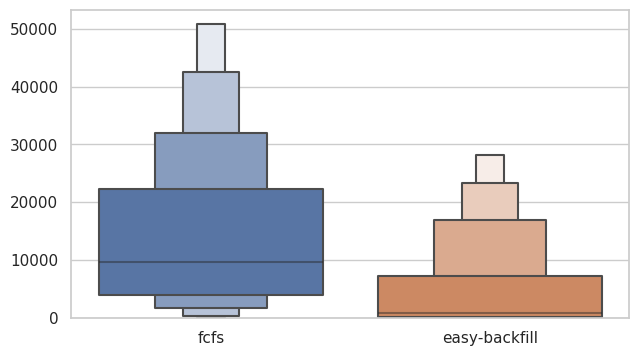

In [22]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/turnaround-time_boxen.pdf', bbox_inches='tight')

In [23]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,fcfs,easy-backfill
count,1589.000000,1589.000000
mean,2159.234031,652.617454
std,4638.480425,2216.194459
min,1.000000,1.000000
25%,62.497055,3.142107
50%,523.051783,16.142852
75%,2096.966211,240.363118
max,58228.010394,27200.041046


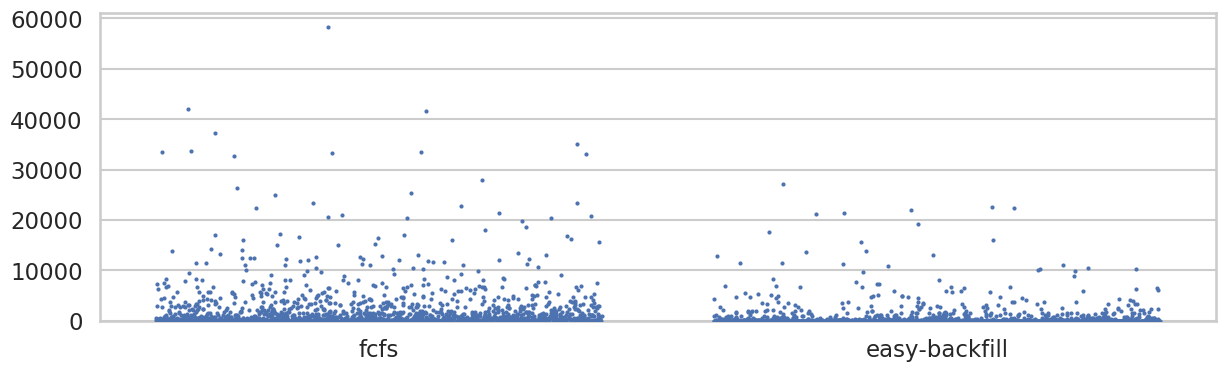

In [24]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/slowdown_dist.pdf', bbox_inches='tight')

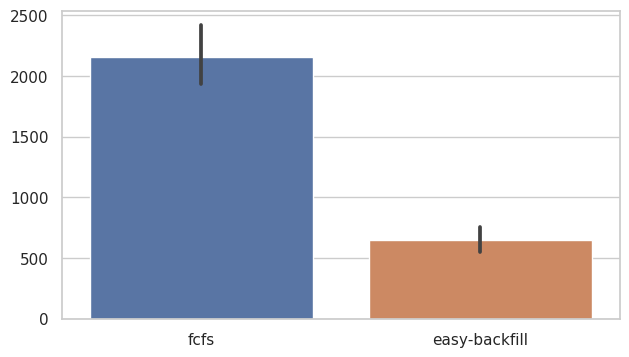

In [25]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=slowdown, ax=ax)
fig.savefig('results/slowdown_mean.pdf', bbox_inches='tight')

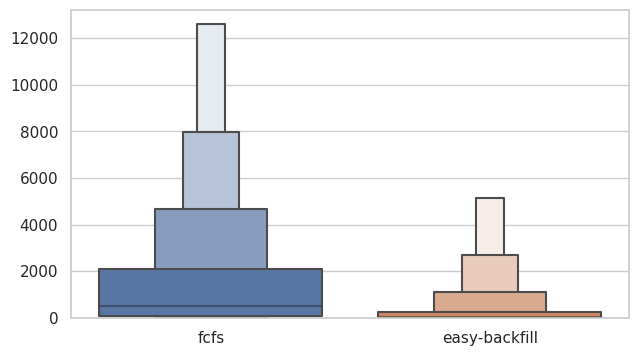

In [26]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/slowdown_boxen.pdf', bbox_inches='tight')

In [27]:
# FCFS

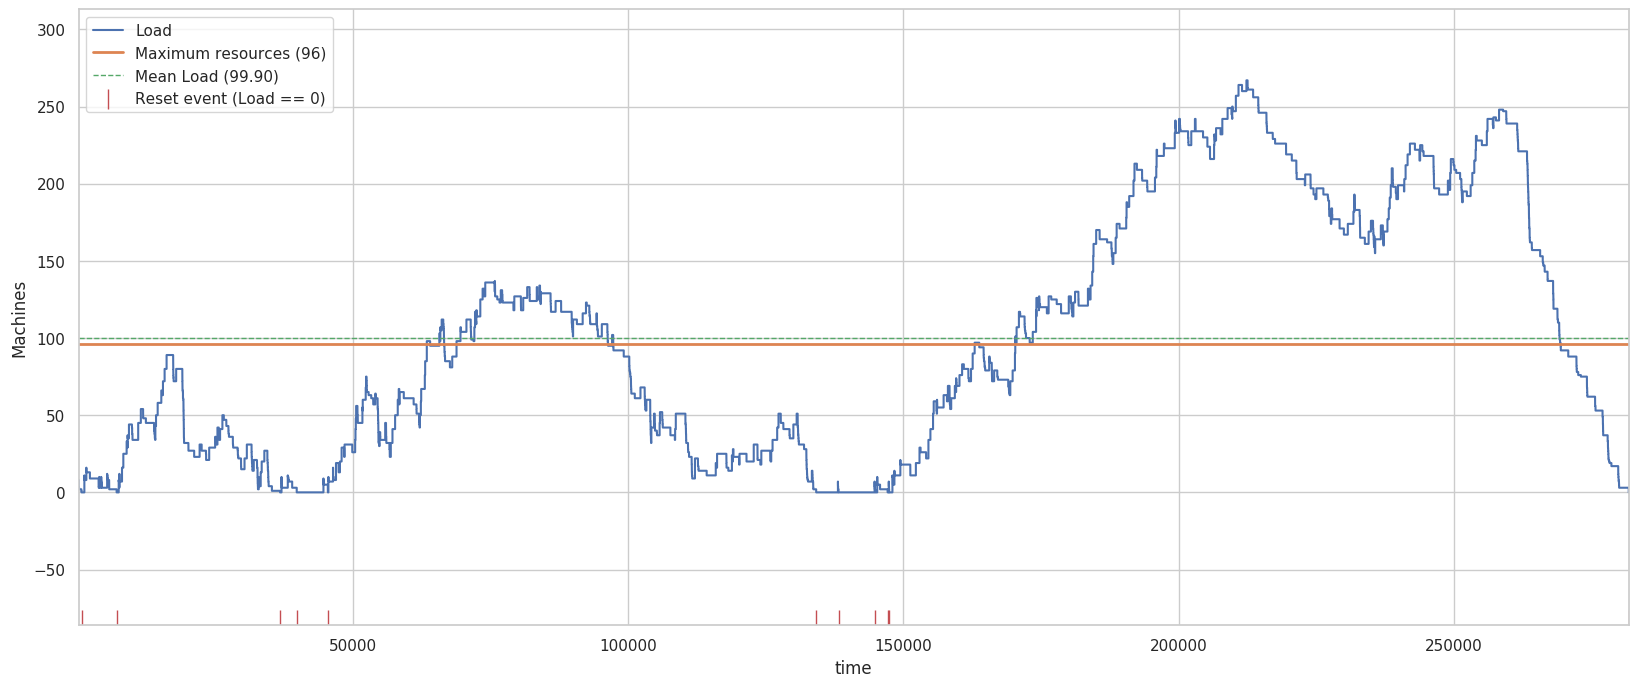

In [28]:
fig, ax = plt.subplots(figsize=(20,8))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)

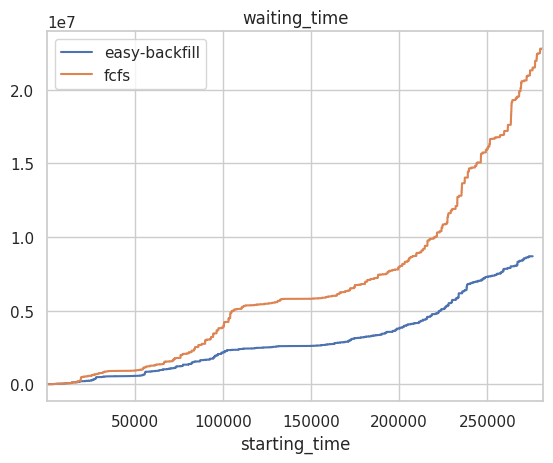

In [29]:
evalys.visu.legacy.plot_series('waiting_time', jobsets)